### 1. Environment Settings

#### 1.1 Import Library

In [45]:
import pandas as pd 
import numpy as np
import random
import os 
import json
import torch
import pickle
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset
from attrdict import AttrDict
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertConfig, BertTokenizer, BertModel

#### 1.2 Setting Default Value

In [6]:
default_path = os.getcwd()
data_path = os.path.join(default_path, 'data')
base_model = os.path.join(default_path, 'base-model')
config_path = os.path.join(default_path, 'config')
log_path = os.path.join(default_path, 'log')
config_file = "bert-base.json"

#### 1.3 Load Dataset 

In [32]:
X_train = pd.read_csv(os.path.join(data_path, 'bws_score_train.csv'))
X_dev = pd.read_csv(os.path.join(data_path, 'bws_score_val.csv'))

#### 1.4 Load Pretrained model & tokenizer 

In [15]:
tokenizer = BertTokenizer.from_pretrained(os.path.join(base_model, 'bert-tiny'), model_max_length=128)
config = BertConfig.from_pretrained(os.path.join(base_model, 'bert-tiny', 'bert_config.json'))
model = BertModel.from_pretrained(os.path.join(base_model, 'bert-tiny'), config=config)

Some weights of the model checkpoint at F:\AuD\base-model\bert-tiny were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### 1.5 setting training args & config 

In [18]:
with open(os.path.join(config_path, 'training_config.json')) as f:
    training_config = AttrDict(json.load(f))

In [19]:
training_config.device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [20]:
training_config

AttrDict({'default_path': '../', 'data_path': 'data', 'log_path': 'log', 'model_path': 'model', 'config_path': 'config', 'seed': 42, 'train_batch_size': 8, 'device': 'cpu', 'eval_batch_size': 8, 'num_epochs': 500, 'gradient_accumulation_steps': 1, 'warmup_proportion': 0, 'adam_epsilon': 1e-08, 'learning_rate': 5e-05, 'do_lower_case': False, 'no_cuda': False, 'max_steps': -1, 'logging_steps': 100})

In [21]:
training_config.learning_rate

5e-05

### 2. Define Class

In [22]:
training_config.pad = 'max_length'
training_config.num_epochs = 500

In [23]:
class BertDataset(Dataset):
    def __init__(self, data_file):
        self.data = data_file
    
    def __len__(self):
        return len(self.data.label)
    
    def reset_index(self):
        self.data.reset_index(inplace=True, drop=True)
    
    def __getitem__(self, idx):
        '''
        return text, label
        '''
        self.reset_index()
        text = self.data.text[idx]
        label = self.data.label[idx]
        return text, label

In [24]:
class BertProcessor():
    def __init__(self, config, training_config, tokenizer, truncation=True):
        self.tokenizer = tokenizer 
        self.max_len = config.max_position_embeddings
        self.pad = training_config.pad
        self.batch_size = training_config.train_batch_size
        self.truncation = truncation
    
    def convert_data(self, data_file):
        context2 = None    # single sentence classification
        batch_encoding = self.tokenizer.batch_encode_plus(
            [(data_file[idx][0], context2) for idx in range(len(data_file))],   # text, 
            max_length = self.max_len,
            padding = self.pad,
            truncation = self.truncation
        )
        
        features = []
        for i in range(len(data_file)):
            inputs = {k: batch_encoding[k][i] for k in batch_encoding}
            try:
                inputs['label'] = data_file[i][1] 
            except:
                # print('input label 오류')
                inputs['label'] = 0 
            features.append(inputs)
        
        all_input_ids = torch.tensor([f['input_ids'] for f in features], dtype=torch.long)
        all_attention_mask = torch.tensor([f['attention_mask'] for f in features], dtype=torch.long)
        all_token_type_ids = torch.tensor([f['token_type_ids'] for f in features], dtype=torch.long)
        all_labels = torch.tensor([f['label'] for f in features], dtype=torch.long)

        dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)
        return dataset
    
    def shuffle_data(self, dataset, data_type):
        if data_type == 'train':
            return RandomSampler(dataset)
        elif data_type == 'eval' or data_type == 'test':
            return SequentialSampler(dataset)
        
    def load_data(self, dataset, sampler):
        return DataLoader(dataset, sampler=sampler, batch_size=self.batch_size)

In [27]:
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

In [28]:
class BertRegressor(nn.Module):
    def __init__(self, config, model):
        super(BertRegressor, self).__init__()
        self.model = model
        self.linear = nn.Linear(config.hidden_size, 128)
        self.relu = nn.ReLU()
        self.out = nn.Linear(128, 1)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        logits = outputs.last_hidden_state[:, 0, :]
        # print(f'logits: {len(logits)}, {len(logits[0])}')
        x = self.linear(logits)
        x = self.relu(x)
        score = self.out(x)
        # print(f'score: {score}')
        return score 

In [29]:
class BertTrainer():
    def __init__(self, config, training_config, model, train_dataloader, eval_dataloader):
        self.config = config
        self.training_config = training_config
        self.model = model
        self.train_dataloader = train_dataloader
        self.eval_dataloader = eval_dataloader
        
    def set_seed(self):
        random.seed(self.training_config.seed)
        np.random.seed(self.training_config.seed)
        torch.manual_seed(self.training_config.seed)
        if not self.training_config.no_cuda and torch.cuda.is_available():
            torch.cuda.manual_seed_all(self.training_config.seed)
    
    def train(self):
        global_step = 0; nb_eval_steps = 0
        train_rmse = []; eval_rmse = []
        t_total = len(self.train_dataloader) // self.training_config.gradient_accumulation_steps * self.training_config.num_epochs

        optimizer = AdamW(self.model.parameters(), lr=self.training_config.learning_rate, eps=self.training_config.adam_epsilon)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(t_total * self.training_config.warmup_proportion), \
                                                    num_training_steps=t_total)
        
        criterion = RMSELoss
        # criterion = nn.MSELoss()
        best_loss = 9999 
        
        self.model.zero_grad()
        for epoch in range(int(self.training_config.num_epochs)):
            train_loss = 0.0; eval_loss = 0.0 
            
            for step, batch in enumerate(self.train_dataloader):
                self.model.train()
                batch = tuple(t.to(self.training_config.device) for t in batch)
                inputs = {
                    "input_ids": batch[0],
                    "attention_mask": batch[1],
                    "token_type_ids": batch[2],
                }
                outputs = self.model(**inputs)
                # print(f'output: {type(outputs)}, {outputs.squeeze}')
                label = batch[3]
                # print(f'label: {label}')
                # print(f'output: {outputs}, {outputs.squeeze()}')
                loss = criterion(outputs.squeeze(), batch[3].type_as(outputs))
                loss.backward()
                
                train_loss += loss.item()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.training_config.max_grad_norm)
                optimizer.step()
                scheduler.step()
                
                self.model.zero_grad()
            
            print(f'epoch: {epoch + 1} done, train_loss: {train_loss / len(self.train_dataloader)}')
            train_rmse.append(train_loss / len(self.train_dataloader))

            for step2, batch2 in enumerate(self.eval_dataloader):
                self.model.eval()
                batch2 = tuple(t.to(self.training_config.device) for t in batch2)

                with torch.no_grad():
                    inputs = {
                        "input_ids": batch2[0],
                        "attention_mask": batch2[1],
                        "token_type_ids": batch2[2],
                    }
                    label2 = batch2[3]
                    outputs = self.model(**inputs)
                    tmp_eval_loss = criterion(outputs.squeeze(), label2.type_as(outputs))
                    eval_loss += tmp_eval_loss.mean().item()
                    
                nb_eval_steps += 1

            eval_loss = eval_loss / nb_eval_steps
            eval_rmse.append(eval_loss)
            if eval_loss < best_loss:
                best_loss = eval_loss
                es = 0
                print(f'save best loss state model & log(epoch {epoch + 1})')
                self.save_model(os.path.join(self.training_config.default_path, self.training_config.model_path, f'bert_bws_{epoch}.pt'))
            else:
                es += 1
                print("Counter {} of 5".format(es))

            if es > 4:
                print("Early stopping with best_loss: ", best_loss, "and val_loss for this epoch: ", eval_loss, "...")
                self.save_model(os.path.join(self.training_config.default_path, self.training_config.model_path, f'bert_bws_best.pt'))
                break
        self.save_log(train_rmse, eval_rmse, epoch+1)
        return train_rmse, eval_rmse
            
    def save_log(self, train_mse, eval_mse, epoch):
        with open(os.path.join(self.training_config.default_path, self.training_config.log_path, f'train_{epoch}_mse.pickle'), 'wb') as f:
            pickle.dump(train_mse, f, pickle.HIGHEST_PROTOCOL)  
        
        with open(os.path.join(self.training_config.default_path, self.training_config.log_path, f'eval_{epoch}_mse.pickle'), 'wb') as f:
            pickle.dump(eval_mse, f, pickle.HIGHEST_PROTOCOL)  
    
    def save_model(self, model_name):
        torch.save(self.model.state_dict(), model_name)

### 3. Model Train

In [31]:
X_train

,text,translated,cnt,weakest_cnt,strongest_cnt,score,minmax_score
542,i've been super resistant to the idea that i a...,나는 최근까지 내가 우울하다는 생각에 매우 저항해왔다. 나는 너무 압도당해서 아무것...,8,0,5,0.625,0.8125
102,i feel sad but i don't if i am really actually...,나는 슬프지만 내가 정말로 우울한지는 모르겠다,8,0,2,0.250,0.6250
637,i just feel like i don't deserve to say that i...,나는 단지 내가 우울하다고 말할 자격이 없다고 느낀다. 왜냐하면 나는 나에게 그렇게...,8,0,1,0.125,0.5625
238,they also don't belive that i am depressed eve...,그들은 또한 내 의사가 몇 달 전에 나를 MDD로 진단했음에도 불구하고 내가 우울하...,8,0,1,0.125,0.5625
1338,But I think it's chilly now,하지만 지금은 쌀쌀한 것 같아요,8,8,0,-1.000,0.0000
...,...,...,...,...,...,...,...
463,any comments suggestions if i am depressed wha...,어떤 댓글이든 내가 우울하면 어떻게 해야 하는지 솔직히 모르겠어,8,0,3,0.375,0.6875
632,and it made me angry because i was paying some...,그리고 그것은 내가 누군가에게 돈을 주고 다음에 우울할 때 일어나서 산책하는 것처럼...,8,0,0,0.000,0.5000
1038,if i feel lonely and isolated and want to find...,만약 내가 외롭고 고립되었다고 느끼고 책에서 위안을 찾고 싶다면 나는 J를 읽는다,8,0,0,0.000,0.5000
1081,as i just said i am unhappy regardless of context,내가 방금 말했듯이 나는 문맥에 상관없이 불행하다,8,0,6,0.750,0.8750


In [34]:
X_train.label.unique()

array([13, 10,  9,  0,  8,  1, 15, 12, 14, 16, 11,  3,  7,  6,  2,  4,  5],
      dtype=int64)

In [35]:
train_file = BertDataset(X_train)
val_file = BertDataset(X_dev)

In [36]:
len(train_file), len(val_file)

(1152, 128)

In [37]:
config.max_position_embeddings = 32
config.max_position_embeddings

32

In [38]:
bert_processor = BertProcessor(config, training_config, tokenizer)

In [39]:
train_dataset = bert_processor.convert_data(train_file)
val_dataset = bert_processor.convert_data(val_file)

In [40]:
train_sampler = bert_processor.shuffle_data(train_dataset, 'train')
val_sampler = bert_processor.shuffle_data(val_dataset, 'eval')

In [41]:
train_dataloader = bert_processor.load_data(train_dataset, train_sampler)
val_dataloader = bert_processor.load_data(val_dataset, val_sampler)

In [42]:
len(train_dataloader), len(val_dataloader)

(144, 16)

In [43]:
model_reg = BertRegressor(config, model).to(training_config.device)  

In [44]:
bert_trainer = BertTrainer(config, training_config, model_reg, train_dataloader, val_dataloader)

In [228]:
train_mse, eval_mse = bert_trainer.train()

epoch: 1 done, train_loss: 8.730203549067179
save best loss state model & log(epoch 1)
epoch: 2 done, train_loss: 7.522732986344232
save best loss state model & log(epoch 2)
epoch: 3 done, train_loss: 6.752065645323859
save best loss state model & log(epoch 3)
epoch: 4 done, train_loss: 6.193689187367757
save best loss state model & log(epoch 4)
epoch: 5 done, train_loss: 5.542160458034939
save best loss state model & log(epoch 5)
epoch: 6 done, train_loss: 4.758662270175086
save best loss state model & log(epoch 6)
epoch: 7 done, train_loss: 4.044101489914788
save best loss state model & log(epoch 7)
epoch: 8 done, train_loss: 3.4134022262361317
save best loss state model & log(epoch 8)
epoch: 9 done, train_loss: 2.9464251034789615
save best loss state model & log(epoch 9)
epoch: 10 done, train_loss: 2.680649767319361
save best loss state model & log(epoch 10)
epoch: 11 done, train_loss: 2.4707671966817646
save best loss state model & log(epoch 11)
epoch: 12 done, train_loss: 2.441190

epoch: 99 done, train_loss: 0.6764412017332183
save best loss state model & log(epoch 99)
epoch: 100 done, train_loss: 0.6300304209192594
Counter 1 of 5
epoch: 101 done, train_loss: 0.6813581710060438
save best loss state model & log(epoch 101)
epoch: 102 done, train_loss: 0.636998159190019
save best loss state model & log(epoch 102)
epoch: 103 done, train_loss: 0.6548252147105005
save best loss state model & log(epoch 103)
epoch: 104 done, train_loss: 0.6984443813562393
Counter 1 of 5
epoch: 105 done, train_loss: 0.6510748101605309
save best loss state model & log(epoch 105)
epoch: 106 done, train_loss: 0.6431237492296431
save best loss state model & log(epoch 106)
epoch: 107 done, train_loss: 0.6486574593517516
Counter 1 of 5
epoch: 108 done, train_loss: 0.6421058550477028
save best loss state model & log(epoch 108)
epoch: 109 done, train_loss: 0.6274502260817422
save best loss state model & log(epoch 109)
epoch: 110 done, train_loss: 0.6622166418366962
save best loss state model & l

epoch: 202 done, train_loss: 0.457380344470342
save best loss state model & log(epoch 202)
epoch: 203 done, train_loss: 0.44554927365647423
Counter 1 of 5
epoch: 204 done, train_loss: 0.4592753541138437
Counter 2 of 5
epoch: 205 done, train_loss: 0.4511765291293462
save best loss state model & log(epoch 205)
epoch: 206 done, train_loss: 0.4554980562792884
save best loss state model & log(epoch 206)
epoch: 207 done, train_loss: 0.4566250716646512
save best loss state model & log(epoch 207)
epoch: 208 done, train_loss: 0.4588734399941232
save best loss state model & log(epoch 208)
epoch: 209 done, train_loss: 0.4268709404600991
Counter 1 of 5
epoch: 210 done, train_loss: 0.4559331031309234
save best loss state model & log(epoch 210)
epoch: 211 done, train_loss: 0.42838386197884876
Counter 1 of 5
epoch: 212 done, train_loss: 0.4763445349203216
Counter 2 of 5
epoch: 213 done, train_loss: 0.4453582829899258
save best loss state model & log(epoch 213)
epoch: 214 done, train_loss: 0.432035492

epoch: 308 done, train_loss: 0.3538840123348766
Counter 3 of 5
epoch: 309 done, train_loss: 0.3826797923280133
save best loss state model & log(epoch 309)
epoch: 310 done, train_loss: 0.3336207614176803
save best loss state model & log(epoch 310)
epoch: 311 done, train_loss: 0.36390185521708596
Counter 1 of 5
epoch: 312 done, train_loss: 0.34973593594299424
save best loss state model & log(epoch 312)
epoch: 313 done, train_loss: 0.3774471580982208
Counter 1 of 5
epoch: 314 done, train_loss: 0.35882802431782085
Counter 2 of 5
epoch: 315 done, train_loss: 0.35836147020260495
Counter 3 of 5
epoch: 316 done, train_loss: 0.35151588833994335
save best loss state model & log(epoch 316)
epoch: 317 done, train_loss: 0.3854202495680915
save best loss state model & log(epoch 317)
epoch: 318 done, train_loss: 0.3921714992158943
Counter 1 of 5
epoch: 319 done, train_loss: 0.36496928830941516
Counter 2 of 5
epoch: 320 done, train_loss: 0.3385783988568518
Counter 3 of 5
epoch: 321 done, train_loss: 0

In [199]:
# bert_trainer.save_model(os.path.join(model_path, 'bert_class.pt'))

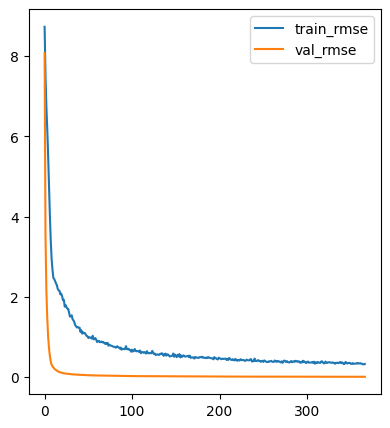

In [229]:
num_epochs = list(range(len(train_mse)))
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(list(range(len(train_mse))), train_mse, label='train_rmse')
plt.plot(list(range(len(eval_mse))), eval_mse, label='val_rmse')

plt.legend()
plt.show()